In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

(heating-rate-profile)=

# Heating rate profiles

In {ref}`heating-rate` we showed that the heating rate $Q_r$ (K/s) for a particular height in
the atmosphere was defined by:

$$
\begin{aligned}
\rho c_p \Delta z \frac{dT}{dt} &= \Delta E_n\\
Q_r = \frac{dT}{dt} &= \frac{1}{\rho c_p} \frac{\Delta E_n}{\Delta z} = \frac{1}{\rho c_p} \frac{dE_n}{dz}
\end{aligned}
$$

where $E_n$ was the net flux integrated over all wavelengths (positive downwards), and $\Delta E_n$ is
the net downward flux $(E_{ntop} - E_{nbot})$ across a layer of thickness $\Delta z$.

In this notebook we use the hydrostatic equation  from {ref}`hydro` and the flux equation
from {ref}`flux_schwartzchild` to find dT/dz as a function of height for an atmosphere with
containing an absorbing gas with a mixing ratio of $r_gas=0.01$ kg/kg and a mass absorption coefficient
averaged across all longwave wavelengths of $k=0.01$   $m^2/kg$.

## Integrate the atmospheric pressure, temperature and density

Recall equation {mat:numref}`hydro`:

$$
dp = -\rho g dz
$$

for a hydrostatic atmosphere, if we assume that dT/dz is constant with height, we can
build up an atmosphere one level at a time, but starting with know $p$, $\rho$ and $T$ at the
surface and using the values of $dT/dz$, $dp/dz$  to find $T$ and $p$ at the next level.  Once
we have those, we can use the ideal gas law to find the density $\rho$ and move up.

This is done in the cell below.

In [2]:
def hydrostat(Temp,height,p_surf):
    """
       build a hydrostatic atmosphere by integrating the hydrostatic equation from the surface,
       given a temperature vs. height profile
       
       Parameters
       ----------

       Temp: ndarray
            vector of air temps (K)
       p_surf: float
            surface pressure in Pa
       height: ndarray
            vector of heights (m)
       delta_z: float
      
       Returns
       -------

       press, rho: tuple of ndarrays the same shape as height and Temp
          where the surface is level 0, and each index i larger than 0
          is located at the height corresponding to the top of a particular layer,
          so that values at the top of the atmosphere are given by index
          numlevels - 1

          press (Pa), rho (kg/m^3) for each layer
    """
    Rd=287. #J/kg/K  -- gas constant for dry air
    g=9.8  #m/s^2
    press=np.empty_like(Temp)
    rho=np.empty_like(Temp)
    #
    # level 0 sits directly above the surface, so start
    # with pressure, temp of air equal to ground temp, press
    # and get density from equaiton of state
    #
    press[0]=p_surf
    rho[0]=p_surf/(Rd*Temp[0])
    num_levels = len(height)
    num_layers=num_levels - 1
    delta_z = np.diff(height)
    #now march up the atmosphere a level at a time
    # finding the values at the top of each layer
    for i in range(num_layers):
        delP= -rho[i]*g*delta_z[i]
        press[i+1]= press[i] + delP
        rho[i+1]=press[i+1]/(Rd*Temp[i+1])
    return (press,rho)

## Next we can find the optical depth

If we have the air density $\rho$, the mixing ratio $r_{mix}$ asnd  the absorption coefficient $k$ from Stull Chapter 2
section 2.3.6 we can find the optical depth in the layer:

$$
\tau = \rho r_{mix} k \Delta z
$$

where $\Delta z$ is the layer thickness.  That's done in the next cell.

In [3]:
def find_tau(r_gas,k,rho,height):
    """
       Parameters
       ----------

       r_gas: float
           gas mixing ratio in kg/kg
       k: float
           mass absorption coefficient in kg/m^2
       rho: ndarray
           vector of air densities in kg/m^3 for each layer
       height: ndarray
        corresponding level heights in m

       Returns
       -------

          tau: ndarray
             vertical optical depths of each level, starting from 0 at the surface
    """
    tau=np.empty_like(rho)
    tau[0]=0
    num_levels=len(rho)
    num_layers=num_levels - 1
    #
    #  left side minus right side
    #
    delta_z=height[1:] - height[:-1]
    for index in range(num_layers):
        delta_tau=r_gas*rho[index]*k*delta_z[index]
        tau[index+1]=tau[index] + delta_tau
    return tau

## Flux with height

Note the factor of 1.666 below that multiplies the optical depth in
the transmission -- this is the flux diffusivity approximation.  The function below
solves for the upward and downward fluxes one layer at at time by calculating
the transmitted flux arriving from the bottom or the top of each layer, and the
emitted flux that the layer is sending to the next layer above or below using the equation given in
{math:numref}`layer_flux`. This is the
"two stream approximation" mentioned in {ref}`two-stream-approx`

Assumption:  layers are thin enough so that it is safe to assume constant values
within each layer

In [20]:
def fluxes(tau,Temp,height,E_solar):
    """
    given properties at each level return the upward and downward
    total flux at each level assuming no downward longwave flux at the top
    of the atmosphere, and a surface flux of sigma*T_surf**4.

    Parameters
    -----------

    tau, Temp, height:  ndarray of length tot_levels
        total optical depth (from surface), temperature (K) and height (m)
        at each level

    Returns
    -------

    up_flux, down_flux: ndarrays
       upward and downward flux of each level (W/m^2), all positive

    """
    sigma=5.67e-8 #W/m^2/K^4
    E_solar=240.  #solar flux in W/m^2
    up_flux=np.empty_like(height)
    down_flux=np.empty_like(height)
    tot_levs = len(height)
    #
    # start at the top of the atmosphere
    # with zero downwelling flux
    #
    down_flux[-1]=0
    #
    # go down a level at a time, adding up the fluxes
    #
    for index in np.arange(1,tot_levs):
        upper_lev=tot_levs - index
        lower_lev=tot_levs - index -1
        del_tau=tau[upper_lev] - tau[lower_lev]
        trans=np.exp(-1.666*del_tau)
        emiss=1 - trans
        layer_flux=sigma*Temp[upper_lev]**4.*emiss
        down_flux[lower_lev]=down_flux[upper_lev]*trans + layer_flux
    #
    # Assume the surface is black, and that its temperature increases
    # quickly to emit just enough flux to balance the sun plus atmosphere
    #
    sfc_flux = down_flux[0] + E_solar
    T_surf = (sfc_flux/sigma)**0.25
    #breakpoint()
    #
    # now start at the surface and go up one level at a time
    #
    up_flux[0]=sfc_flux
    for index in np.arange(1,tot_levs):
        upper_lev=index
        lower_lev=index - 1
        del_tau=tau[upper_lev] - tau[lower_lev]
        trans=np.exp(-del_tau)
        emiss=1 - trans
        layer_flux=sigma*Temp[lower_lev]**4.*emiss
        #
        # find the flux at the next level
        #
        up_flux[upper_lev]=trans*up_flux[lower_lev] + layer_flux

    return (up_flux,down_flux, T_surf)

In [5]:
def heating_rate(net_down,height,rho):
    """
    given the net flux at each level (downward positive) and the
    height, and density of the atmosphere at each level, return
    the rate of change of temperature in each layer between two levels

    Parameters
    ----------

    net_down: ndarray
       positive downward net flux (W/m^2) at each level

    height: ndarray
       vertical location of each level (m)

    rho: ndarray
       density (kg/m^3) at each level

    Returns
    -------

    dT_dt: ndarray  -- length nlevels -1
       time rate of change of temperature (K/s)


    """

    cpd=1004.
    #
    # find the flux divergence across the layer
    # by differencing the levels.  Assume the layer density is constant
    # and equal to the average of the densities at the top and bottom levels
    #
    rho_mid=(rho[1:] + rho[:-1])/2.
    dEn_dz= np.diff(net_down)/np.diff(height)
    dT_dt=dEn_dz/(rho_mid*cpd)
    return dT_dt

In [6]:
inputs=dict(
    r_gas=0.01,  #kg/kg
    k=0.006,  #m^2/kg
    E_solar = 240,  #W/m^2
    p_surf=100.e3, #Pa
    delta_z=100,  #m
    delta_t = 1800., #s
    num_timesteps=7000,
    num_levels=200,
    T_surf=300.  #K
)

def init_profs(inputs,lapse_rate):
    Tstart=inputs['T_surf']
    lapse_rate = -7.e-3
    Tstop= Tstart + inputs['num_levels']*inputs['delta_z']*lapse_rate
    Temp=np.linspace(Tstart,Tstop,inputs['num_levels'])
    hbot = 0
    htop = inputs['num_levels']*inputs['delta_z']
    height = np.linspace(hbot,htop,inputs['num_levels'])
    return Temp, height



def main(Temp,height,r_gas=None, k=None,p_surf=None,delta_t=None,delta_z=None,
          num_timesteps=None,num_levels=None,E_solar=None,
          T_surf=None):
    """
    find the heating rate (K/km) for a hydrostatic
    atmosphere with a constant decrease of temperature with heigt
    """
    #
    #
    #
    press,rho=hydrostat(Temp,height,p_surf)
    tau=find_tau(r_gas,k,rho,height)
    #breakpoint()
    up,down,T_surf=fluxes(tau,Temp,height,E_solar)
    net_down = down - up
    dT_dt=heating_rate(down - up,height,rho)
    
    df=pd.DataFrame(height,columns=['height'])
    df['height_km'] = height*1.e-3
    df['up'] = up
    df['down'] = down
    df['net_down'] = net_down
    

    fig,(axis1,axis2,axis3)=plt.subplots(1,3,figsize=(15,10))
    axis1.plot('up','height_km','b-',lw=5,label='upward flux',data=df)
    axis1.plot(down,'height_km','g-',lw=5,label='downward flux',data=df)
    axis1.set_title('upward and downward fluxes')
    axis1.set_xlabel('flux $(W\,m^{-2}$')
    axis1.set_ylabel('height (km)')
    axis1.legend(numpoints=1,loc='best')
    axis1.grid(True)


    axis2.plot('net_down','height_km','b-',lw=5,data=df)
    axis2.set_title('net downward flux')
    axis2.set_xlabel('net downward flux $(W\,m^{-2})$')
    axis2.set_ylabel('height (km)')
    axis2.grid(True)


    dT_dt=dT_dt*3600.*24.
    mid_height=(height[1:] + height[:-1])/2.
    axis3.plot(dT_dt,mid_height*0.001,'b-',lw=5)
    axis3.set_title('heating rate')
    axis3.set_xlabel('heating rate in K/day')
    axis3.set_ylabel('height (km)')
    axis3.grid(True)

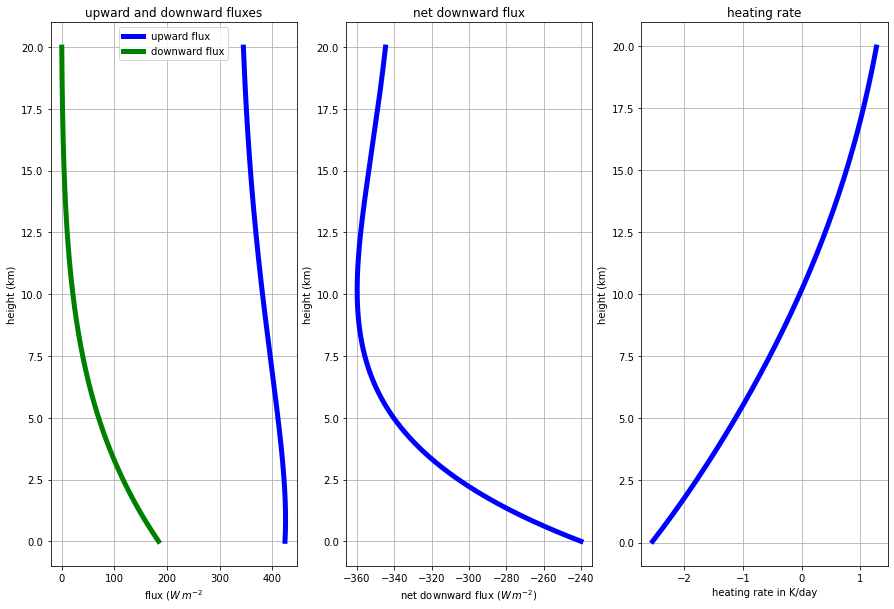

In [7]:
lapse_rate = -7.e-3
Tinit,height = init_profs(inputs,lapse_rate)
main(Tinit,height,**inputs)

In [8]:
def evolve(Temp,height,r_gas=None, k=None,p_surf=None,delta_t=None,delta_z=None,
          num_timesteps=None,num_levels=None,E_solar=None,
          T_surf=None):
    """
    find the heating rate (K/km) for a hydrostatic
    atmosphere with a constant decrease of temperature with heigt
    """
    sigma=5.67e-8

    dT_dz = np.ones([num_levels])*(-7.e-3)
    #
    # 1-D
    #
    nvars=2
    keep_sfc = np.empty([nvars,num_timesteps])
    #
    # vars,height,timesteps
    #
    nvars=5
    keep_vals=np.empty([nvars,num_levels,num_timesteps])
    press,rho=hydrostat(Temp,height,p_surf)
    #breakpoint()
    for time_index in range(num_timesteps):
        tau=find_tau(r_gas,k,rho,height)
        up,down,T_surf=fluxes(tau,Temp,height,E_solar)
        keep_sfc[0,time_index] =T_surf
        keep_sfc[1,time_index]=time_index*delta_t
        net_down = down - up
        dT_dt=heating_rate(net_down,height,rho)
        Temp[:-1] = Temp[:-1] + dT_dt*delta_t
        Temp[-1]=Temp[-2]  
        dT_dt_p1=np.append(dT_dt,dT_dt[-1])
        for i,the_vec in enumerate([Temp,tau,up,down,dT_dt_p1]):
            keep_vals[i,:,time_index]=the_vec
        press,rho=hydrostat(Temp,height,p_surf)
        #breakpoint()
    return keep_vals,keep_sfc

In [9]:
inputs=dict(
    r_gas=0.01,  #kg/kg
    k=0.02,  #m^2/kg
    E_solar = 240,
    p_surf=100.e3, #Pa
    delta_z=100,  #m
    delta_t = 1800.,
    num_timesteps=7000,
    num_levels=200,
    T_surf=310.
)

lapse_rate = -7.e-3

Tinit,height = init_profs(inputs,lapse_rate)

keep_vals,keep_sfc=evolve(Tinit,height,**inputs)

         Temp       tau          up        down         dT_dt
0  286.014592  0.000000  528.842492  288.842492 -5.877476e-08
1  285.329564  0.024487  525.228352  285.221162 -5.928304e-08
2  284.646106  0.048738  521.648395  281.634022 -5.978697e-08
3  283.964234  0.072756  518.102402  278.080856 -6.028652e-08
4  283.283966  0.096540  514.590157  274.561448 -6.078167e-08
200


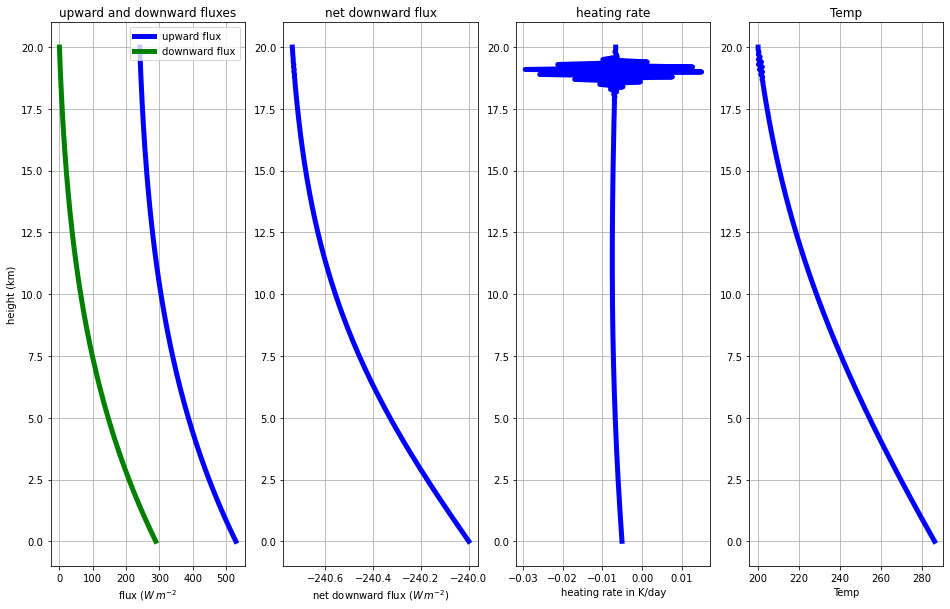

In [10]:
frame0 = keep_vals[:,:,-1]

df=pd.DataFrame(frame0.T,columns=['Temp','tau','up','down','dT_dt'])
print(df.head())
print(len(height))

def make_plot(df):

    fig,(axis1,axis2,axis3,axis4)=plt.subplots(1,4,figsize=(16,10))
    axis1.plot('up',height*0.001,'b',data=df,lw=5,label='upward flux')
    axis1.plot('down',height*0.001,'g',data=df,lw=5,label='downward flux')
    axis1.set_title('upward and downward fluxes')
    axis1.set_xlabel('flux $(W\,m^{-2}$')
    axis1.set_ylabel('height (km)')
    axis1.legend(numpoints=1,loc='best')
    axis1.grid(True)

    net_down = df['down'] - df['up']
    axis2.plot(net_down,height*0.001,'b-',lw=5)
    axis2.set_title('net downward flux')
    axis2.set_xlabel('net downward flux $(W\,m^{-2})$')
    axis2.grid(True)

    df['dT_dt_day']=df['dT_dt']*3600.*24.
    axis3.plot('dT_dt_day',height*0.001,'b-',data=df,lw=5)
    axis3.set_title('heating rate')
    axis3.set_xlabel('heating rate in K/day')
    axis3.grid(True)


    varname='Temp'
    axis4.plot(varname,height*0.001,'b-',data=df,lw=5)
    axis4.set_title(varname)
    axis4.set_xlabel(varname)
    axis4.grid(True)

make_plot(df)

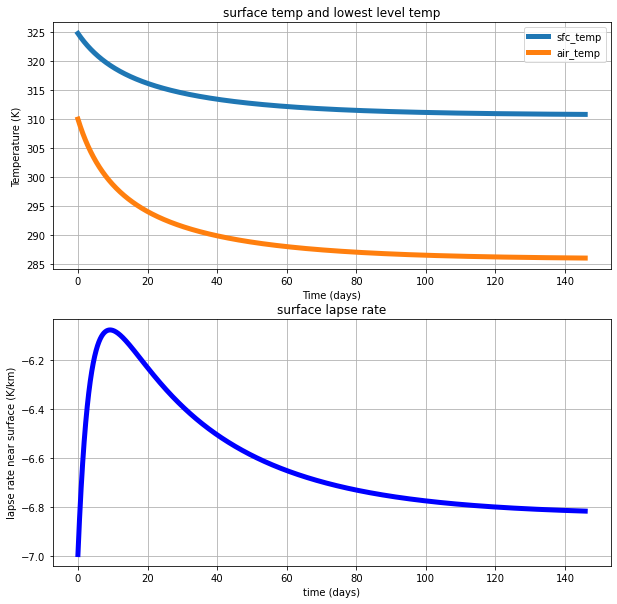

In [19]:
air_temp = keep_vals[0,0,:]
df = pd.DataFrame(keep_sfc.T,columns=['sfc_temp','time_seconds'])
df['time_days']=df['time_seconds']/3600./24.
df['air_temp']=air_temp
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
varnames=['sfc_temp','air_temp']
for a_name in varnames:
    ax1.plot('time_days',a_name,data=df,label=a_name,lw=5);
ax1.grid(True)
ax1.legend()
ax1.set_xlabel("Time (days)")
ax1.set_ylabel("Temperature (K)")
ax1.set_title('surface temp and lowest level temp')
dT = keep_vals[0,1,:] - keep_vals[0,0,:]
dz = np.diff(height)[0]
lapse_rate = dT/dz*1.e3
ax2.plot(df['time_days'],lapse_rate,'b',lw=5)
ax2.set_xlabel('time (days)')
ax2.set_ylabel('lapse rate near surface (K/km)')
ax2.set_title('surface lapse rate')
ax2.grid(True)